In [ ]:
!pip install transformers accelerate safetensors torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 860.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
!pip install transformers accelerate sentencepiece

In [ ]:
from google.colab import files
import zipfile, os
from PIL import Image

uploaded = files.upload()

for fname in uploaded:
    if fname.endswith('.zip'):
        folder_name = os.path.splitext(fname)[0]
        with zipfile.ZipFile(fname, 'r') as zip_ref:
            zip_ref.extractall(folder_name)
        print(f"✅ Extracted to: {folder_name}")

In [ ]:
import os
import json
from PIL import Image
import requests
from bs4 import BeautifulSoup

# ==== CONFIG ====
image_folder = "VLM task food/VLM task food"
output_json_path = "dish_metadata.json"
valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')

# ==== Scrape instructions from AllRecipes ====
def get_allrecipes_instructions(dish_name):
    try:
        query = dish_name.replace('_', '+')
        url = f"https://www.allrecipes.com/search?q={query}"
        headers = {"User-Agent": "Mozilla/5.0"}
        search_resp = requests.get(url, headers=headers)
        soup = BeautifulSoup(search_resp.content, "html.parser")

        first_result = soup.select_one("a.card__titleLink")
        if not first_result:
            return ["No instructions found."]

        recipe_url = first_result["href"]
        recipe_resp = requests.get(recipe_url, headers=headers)
        recipe_soup = BeautifulSoup(recipe_resp.content, "html.parser")

        instructions = recipe_soup.select("ul.instructions-section li p")
        steps = [step.get_text(strip=True) for step in instructions]

        return steps if steps else ["No steps found."]
    except Exception as e:
        return [f"Error fetching instructions: {e}"]

# ==== MAIN LOOP ====
metadata_list = []
import time
contents = os.listdir(image_folder)

for fname in contents:
    file_path = os.path.join(image_folder, fname)

    if os.path.isdir(file_path) or not fname.lower().endswith(valid_exts):
        continue

    try:
        image = Image.open(file_path).convert("RGB")

        # Ask user for noisy title instead of using Gemini
        noisy_title = input(f"🎭 Enter a noisy title for {fname}: ")

        # Get original dish name (without extension) for recipe search
        search_name = os.path.splitext(fname)[0]
        print(f"🔍 Searching AllRecipes for: {search_name}")
        instructions = get_allrecipes_instructions(search_name)

        # Ask user for summary
        summary = input(f"📝 Enter summary for {fname}: ")

        metadata_list.append({
            "file_name": fname,
            "noisy_title": noisy_title,
            "instructions": instructions,
            "summary": summary
        })

        print(f"✅ Done: {fname} → '{noisy_title}'")

    except Exception as e:
        print(f"❌ Error processing {fname}: {e}")
    time.sleep(1)

# ==== SAVE JSON ====
with open(output_json_path, "w", encoding="utf-8") as f:
    json.dump(metadata_list, f, indent=4, ensure_ascii=False)

print(f"\n✅ JSON saved to: {output_json_path}")


***LLAVA MODEL***

In [ ]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
import torch, gc
from PIL import Image
import requests
from transformers import LlavaProcessor

In [ ]:
def generate_summary(image_path, noisy_title):
    model_id = "llava-hf/llava-1.5-7b-hf"

    model = LlavaForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        low_cpu_mem_usage=True,
    ).to(0)

    processor = AutoProcessor.from_pretrained(model_id)

    torch.cuda.empty_cache()
    gc.collect()

    image = Image.open(image_path).convert("RGB")

    system_prompt = (
        "You are a helpful cooking assistant. Generate a concise 2–3 step cooking summary on how to make the dish. Include all important ingredients in the instructions itself. Keep the summary concise. "
        "based on a food image and a noisy or vague title. Use these examples:\n\n"
        "Image: Cinnamon_rolls\n"
        "Noisy title: Snap and Swirl Rolls\n"
        "Summary: Mix warm milk, melted margarine, flour, sugar, yeast, salt, egg, and water into dough; knead and let rest. Roll out dough, spread cinnamon-sugar filling with raisins, roll up, slice, and bake at 375°F for 20 min.\n\n"
        "Image: Cheesy_garlic_bread\n"
        "Noisy title: Savory Bread Melt\n"
        "Summary: Butter bread, add garlic powder, Parmesan, mozzarella. Broil until golden, top with parsley.\n\n"
        "Image: rajma\n"
        "Noisy title: Spiced Bean Lava\n"
        "Summary: Soak kidney beans overnight. Sauté spices, add tomatoes, pressure cook beans, stir in garam masala, garnish.\n\n"
        "Image: ratatouille\n"
        "Noisy title: Veggie Swirl Stew\n"
        "Summary: Mix tomato paste, onion, garlic, water, olive oil base. Layer vegetables, drizzle oil, season, bake 375°F 45 min.\n\n"
        "Image: naan\n"
        "Noisy title: Yeast Flat\n"
        "Summary: Mix yeast, sugar, warm water; sit 10 min. Add flour, salt, yogurt, ghee; knead, rise 1.5 hrs. Shape, brush ghee, broil 2 min sides.\n\n"
        "Image: strawberry_drink\n"
        "Noisy title: Pink Velvet Pour\n"
        "Summary: Blend strawberries, amaretto, vanilla ice cream, extract, vodka, ice. Pour, top with whipped cream and strawberry.\n\n"
        "Image: fried_rice\n"
        "Noisy title: Golden Grain Toss\n"
        "Summary: Boil carrots briefly, add peas, drain. Stir-fry with garlic, scramble eggs, add rice, toss with soy sauce, sesame oil.\n"
    )

    conversation = [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_prompt}],
        },
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": f"noisy dish title: {noisy_title}"},
                {"type": "text", "text": "Please provide a concise 2–3 step summary on how to make the dish."},
            ],
        },
    ]

    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

    inputs = processor(images=image, text=prompt, return_tensors="pt").to(0, torch.float16)

    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=100)

    torch.cuda.empty_cache()
    gc.collect()

    response = processor.batch_decode(output[:, inputs["input_ids"].shape[-1]:], skip_special_tokens=True)[0]

    return response

In [ ]:
def load_and_resize(path, size=(336, 336)):
    return Image.open(path).convert("RGB").resize(size)

In [ ]:
from google.colab import files
import json
from PIL import Image
uploaded = files.upload()

Saving breakfast_strata.jpeg to breakfast_strata.jpeg
Saving broccoli_alfredo_pasta.jpg to broccoli_alfredo_pasta.jpg
Saving chana_masala.jpg to chana_masala.jpg
Saving chicken_fajita.jpeg to chicken_fajita.jpeg
Saving chicken_makhani.jpg to chicken_makhani.jpg
Saving chicken_ramen.jpeg to chicken_ramen.jpeg
Saving chicken_soup.jpg to chicken_soup.jpg
Saving chocolate_tart.jpeg to chocolate_tart.jpeg
Saving lasagna.jpeg to lasagna.jpeg
Saving pasta_salad.jpeg to pasta_salad.jpeg
Saving red_velvet_cupcakes.jpeg to red_velvet_cupcakes.jpeg
Saving rice_kheer.jpeg to rice_kheer.jpeg
Saving samosa.jpeg to samosa.jpeg
Saving schezuan_green_beans.jpeg to schezuan_green_beans.jpeg
Saving thai_green_curry.jpeg to thai_green_curry.jpeg


In [ ]:
uploaded = files.upload()

Saving cheesy_garlic_bread.jpg to cheesy_garlic_bread.jpg
Saving cinnamon_rolls.jpeg to cinnamon_rolls.jpeg
Saving fried_rice.jpeg to fried_rice.jpeg
Saving naan.jpg to naan.jpg
Saving rajma.jpeg to rajma.jpeg
Saving ratatouille.jpg to ratatouille.jpg
Saving strawberry_drink.jpeg to strawberry_drink.jpeg
Saving system_prompt_examples.json to system_prompt_examples.json


In [ ]:
uploaded = files.upload()

Saving fried_rice.jpeg to fried_rice.jpeg
Saving naan.jpg to naan.jpg
Saving rajma.jpeg to rajma.jpeg
Saving ratatouille.jpg to ratatouille.jpg
Saving strawberry_drink.jpeg to strawberry_drink.jpeg


***VIEWING THE TEST DATASET***

Title: peppery chicken sizzle
Summary: Whisk vegetable oil, chili powder, lime juice, honey, garlic powder, paprika, and black pepper together. Add chicken, let it sit. Grill until brown.



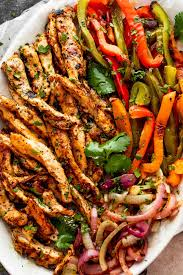

Title: crimson sweet bites
Summary: Beat sugar, butter and eggs. Add sour cream, vanilla and red coloring. Mix in cocoa powder, flour, baking soda, salt.



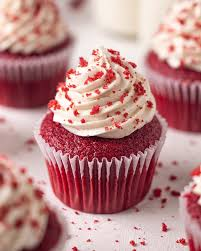

Title: milky rice pudding
Summary: Boil coconut milk, milk and sugar in a pan. Add cardamom, pistachios, raisins after it thickens.



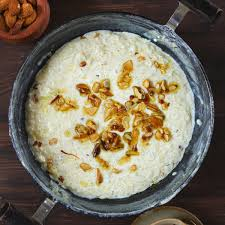

Title: crispy spiced pocket
Summary: Mix flour and oil for a firm dough. Cook mashed potatoes with peas and spices for filling. Roll dough, shape into cones, fill, seal, and deep-fry until golden and crispy.



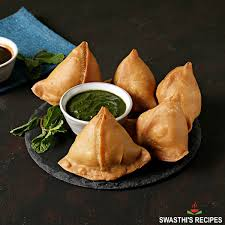

Title: Cheesy Eggy Bake Stack
Summary: Cook sausage and mushrooms, then layer in a dish. Mix bread, eggs, cheese, veggies, and seasonings; pour over sausage. Chill, then bake at 350°F for about an hour until set and golden.



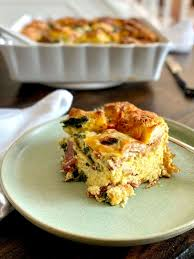

Title: Creamy Coconut Spice Bowl
Summary: Toss chicken in soy sauce and flour, then brown in a skillet. Sauté curry paste, add chicken back, stir in coconut milk, soy sauce, and fish sauce. Simmer until tender and serve with cilantro.



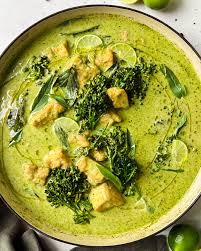

Title: zesty crunch bowl
Summary: Cook rotini pasta, rinse, and combine with pepperoni, cheese, veggies, and herbs. Shake olive oil and spices to make a dressing, then toss it all together. May chill before serving.



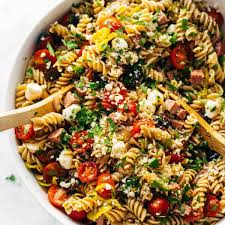

Title: Cheesy Layered Oven Melt
Summary: Brown meat with onions and simmer in tomato sauce. Cook noodles and mix cheeses with eggs and herbs. Layer sauce, noodles, and cheese; bake until golden.



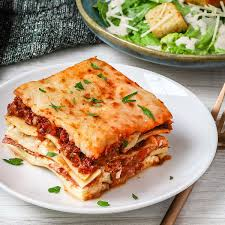

Title: Creamy Green Cheesy Twirls
Summary: Cook pasta until soft and steam broccoli until bright green. Simmer butter, cream, garlic, and cheese to make Alfredo sauce, thinning with pasta water if needed. Toss pasta and broccoli in the sauce, then serve.



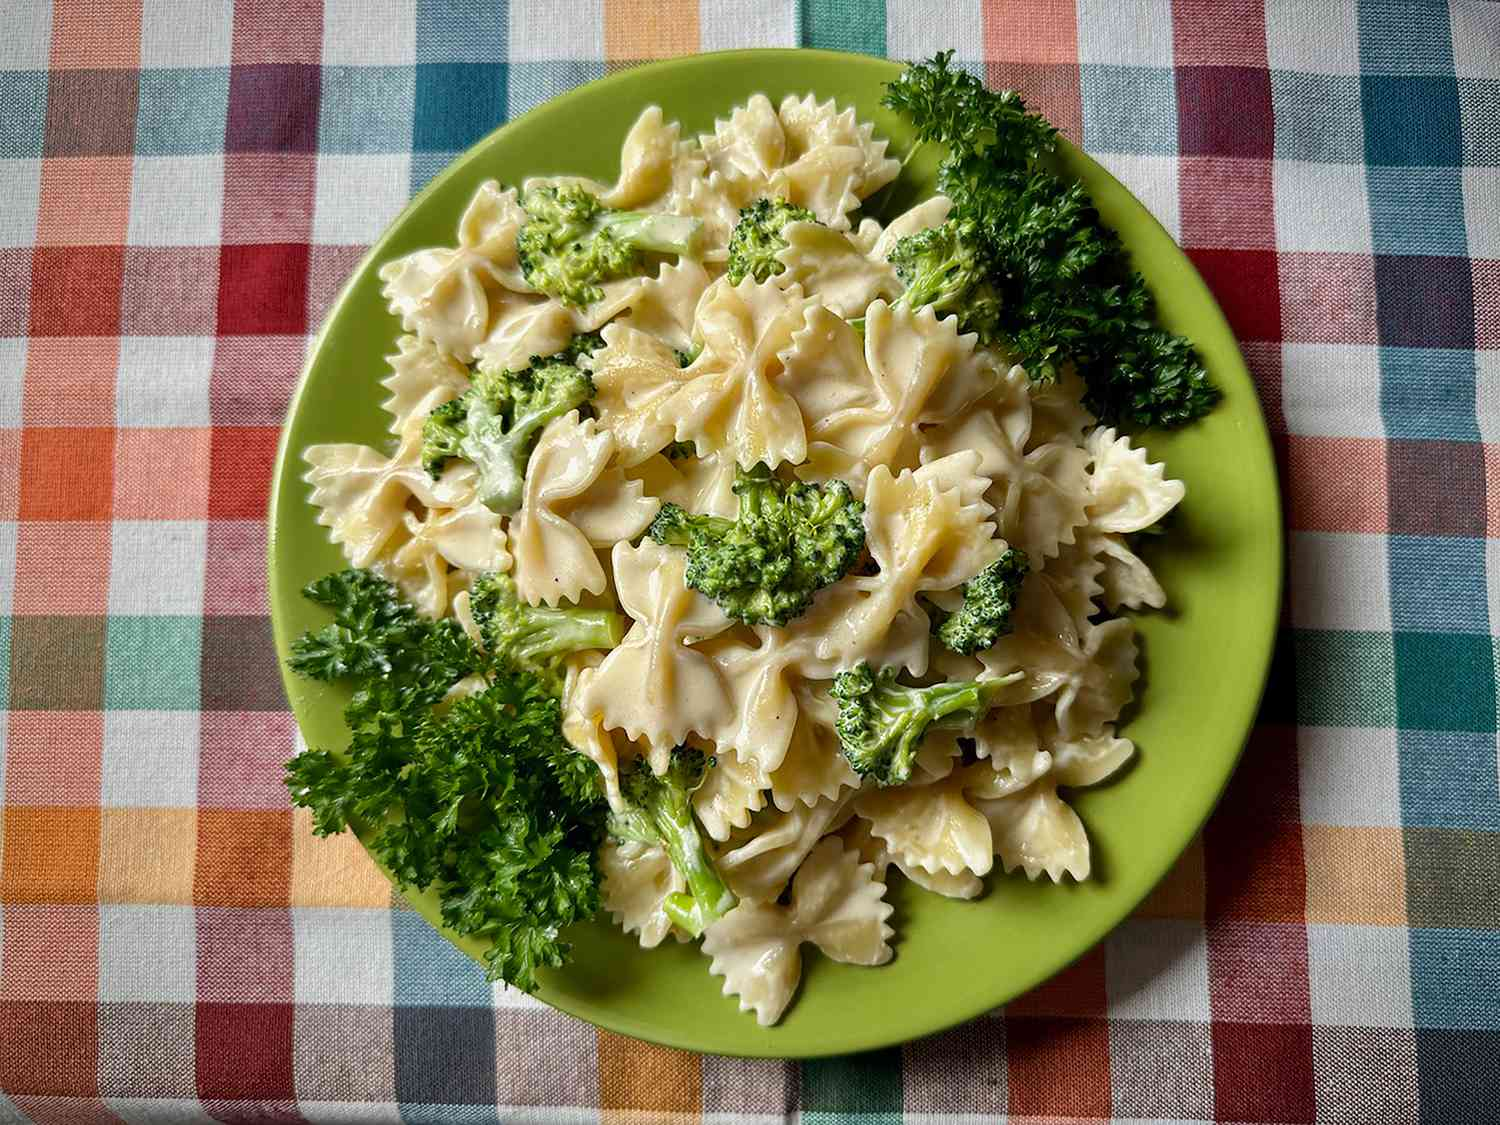

In [ ]:
import json
from IPython.display import display
with open("/content/Test_dataset.json") as f:
    data = json.load(f)
for item in data:
    filename = item["file_name"]
    title = item.get("noisy_title")
    summary = item["summary"]

    print(f"Title: {title}\nSummary: {summary}\n")


    img = Image.open(filename)
    display(img)

In [ ]:
import gc
gc.collect()
import gc
import torch

***JSON LOOP***

In [ ]:
import json
with open("/content/Test_dataset.json") as f:
    data = json.load(f)
results = []

for item in data:
    filename = item["file_name"]
    noisy_title = item.get("noisy_title")
    summary = generate_summary(filename,noisy_title)
    print(f"{filename} → {summary}")
    results.append({
        "file_name": filename,
        "noisy_title": noisy_title,
        "summary": summary,
    })
    torch.cuda.empty_cache()
    gc.collect()

with open("summary_results.json", "w") as out_f:
    json.dump(results, out_f, indent=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

chicken_fajita.jpeg → Marinate chicken with spices, onions, garlic, and lime juice. Grill chicken until cooked through. Serve with a side of mixed vegetables, including carrots, peppers, and onions.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

red_velvet_cupcakes.jpeg → Mix warm milk, melted margarine, flour, sugar, yeast, salt, egg, and water into dough; knead and let rest. Roll out dough, spread cinnamon-sugar filling with raisins, roll up, slice, and bake at 375°F for 20 min.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

rice_kheer.jpeg → Mix milk, sugar, and vanilla extract in a saucepan. Add rice, raisins, and nuts. Cook over low heat, stirring occasionally, until the rice is tender and the pudding is set. Serve warm.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

***CLEARING GPU MEMORY***

In [ ]:
import torch
import gc
for var in ['model', 'inputs', 'output', 'response', 'processor']:
    try:
        del globals()[var]
    except KeyError:
        pass
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
import torch
import gc

def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

clear_gpu_memory()

***EVALUATION- Bleu Score***

In [ ]:
!pip install nltk

In [ ]:
import json
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

reference_path = "Test_dataset.json"
generated_path = "summary_results.json"

with open(reference_path, "r") as f:
    reference_json = json.load(f)

with open(generated_path, "r") as f:
    generated_json = json.load(f)

refs = {item["file_name"]: item["summary"] for item in reference_json}
gens = {item["file_name"]: item["summary"] for item in generated_json}

def tokenize(text):
    return text.lower().split()

smooth_fn = SmoothingFunction().method1

bleu_scores = []

for filename in refs:
    ref_summary = refs[filename]
    gen_summary = gens.get(filename)

    if gen_summary is None:
        print(f"{filename}: No generated summary found.")
        continue

    ref_tokens = [tokenize(ref_summary)]
    gen_tokens = tokenize(gen_summary)

    if gen_tokens:
        score = sentence_bleu(ref_tokens, gen_tokens, smoothing_function=smooth_fn)
        print(f"{filename}: BLEU = {score:.4f}")
        bleu_scores.append(score)
    else:
        print(f"{filename}: Generated summary is empty.")

average_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
print(f"\nAverage BLEU score: {average_bleu:.4f}")


chicken_fajita.jpeg: BLEU = 0.0103
red_velvet_cupcakes.jpeg: BLEU = 0.0142
rice_kheer.jpeg: BLEU = 0.0155
samosa.jpeg: BLEU = 0.0104
breakfast_strata.jpeg: BLEU = 0.0441
thai_green_curry.jpeg: BLEU = 0.0132
pasta_salad.jpeg: BLEU = 0.0063
lasagna.jpeg: BLEU = 0.1003
broccoli_alfredo_pasta.jpg: BLEU = 0.0065

Average BLEU score: 0.0245
